In [1]:
import pandas as pd
import json
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
import re
from dateutil import parser
import json
import ipaddress

In [2]:
ignoreList = ['.length ']
matchPatterns = []
def tokenize_filter(filter_dict):
    tokens = []
    if filter_dict is not None:
        filter_str = json.dumps(filter_dict)
        tokens = re.findall(r"\[\w']+|\[.,!?;\]", filter_str)
    return tokens

def replace_alpha_words(text):
    regex = r"^(?!\$)\w+"
    return re.sub(r"'[\w ]+'", '\'name\'', text)

def replace_this_var(text):
    matched = (re.findall(r"\.[\w]+",text))
    #matchPatterns.append(matched)
    for matches in matched:
        if str(matches) != '.length':
            text = re.sub(matches,".name",text)
        else:
            matchPatterns.append(matches)
    return text

def replace_this_var_condi(text):
    regex = r"^(?!\$)\w+"
    return re.sub(r"\.[\w]+[\.]",".name.",text)

In [3]:
labelData = pd.read_json("../No-SQL_Gen/No-SqlDataset.json")
labelData['text'] = labelData['text'].apply(lambda x: x.replace('"', "'") if isinstance(x, str) else x)
labelData.head()

,text,label
0,"{'user': '{}', 'password': '{}'}",0
1,{'username': {'$regex': '^{}'}},1
2,{'username': {'$ne': '{}'}},1
3,{'username': {'$gt': '{}'}},1
4,"{'user': 'hacker', 'password': {'$ne': ''}}",1


In [4]:
logData = pd.read_json('../Dataset/queryLogs.json')
logData.head()
logData['t'] = logData['t'].apply(lambda x: parser.parse(x['$date']).timestamp())
attr_cols = ['type', 'ns', 'command', 'planSummary', 'planningTimeMicros', 'keysExamined', 'docsExamined', 'nBatches', 'cursorExhausted', 'numYields', 'nreturned', 'queryFramework', 'reslen', 'locks', 'storage', 'cpuNanos', 'remote', 'protocol', 'durationMillis']
for col in attr_cols:
    logData[col] = logData['attr'].apply(lambda x: x.get(col, None))
logData['FindCollectionTarget'] = logData['command'].apply(lambda x: x.get('find', None) if isinstance(x, dict) else None)
logData['filter'] = logData['command'].apply(lambda x: x.get('filter', None) if isinstance(x, dict) else None)
logData['tokenized_filter'] = logData['filter'].apply(lambda x: tokenize_filter(str(x)) if x is not None else None)
logData['lsid.id.$uuid'] = logData['command'].apply(lambda x: x.get('lsid', {}).get('id', {}).get('$uuid', None) if isinstance(x, dict) else None)
logData['$db'] = logData['command'].apply(lambda x: x.get('$db', None) if isinstance(x, dict) else None)
logData['filter_str'] = logData['filter'].apply(lambda x: str(x) if x is not None else None)
logData.head()

,t,s,c,id,ctx,msg,attr,type,ns,command,...,cpuNanos,remote,protocol,durationMillis,FindCollectionTarget,filter,tokenized_filter,lsid.id.$uuid,$db,filter_str
0,1.712243e+09,I,COMMAND,51803,conn10,Slow query,"{'type': 'command', 'ns': 'test_database.test_...",command,test_database.test_collection,"{'find': 'test_collection', 'filter': {'user':...",...,176371,127.0.0.1:47038,op_msg,0,test_collection,"{'user': '{}', 'password': '{}'}",[],e5e23d7e-5367-4829-a104-ca369c49d4dc,test_database,"{'user': '{}', 'password': '{}'}"
1,1.712243e+09,I,COMMAND,51803,conn10,Slow query,"{'type': 'command', 'ns': 'test_database.test_...",command,test_database.test_collection,"{'find': 'test_collection', 'filter': {'userna...",...,112781,127.0.0.1:47038,op_msg,0,test_collection,{'username': {'$regex': '^{}'}},[],e5e23d7e-5367-4829-a104-ca369c49d4dc,test_database,{'username': {'$regex': '^{}'}}
2,1.712243e+09,I,COMMAND,51803,conn10,Slow query,"{'type': 'command', 'ns': 'test_database.test_...",command,test_database.test_collection,"{'find': 'test_collection', 'filter': {'userna...",...,71093,127.0.0.1:47038,op_msg,0,test_collection,{'username': {'$ne': '{}'}},[],e5e23d7e-5367-4829-a104-ca369c49d4dc,test_database,{'username': {'$ne': '{}'}}
3,1.712243e+09,I,COMMAND,51803,conn10,Slow query,"{'type': 'command', 'ns': 'test_database.test_...",command,test_database.test_collection,"{'find': 'test_collection', 'filter': {'userna...",...,81173,127.0.0.1:47038,op_msg,0,test_collection,{'username': {'$gt': '{}'}},[],e5e23d7e-5367-4829-a104-ca369c49d4dc,test_database,{'username': {'$gt': '{}'}}
4,1.712243e+09,I,COMMAND,51803,conn10,Slow query,"{'type': 'command', 'ns': 'test_database.test_...",command,test_database.test_collection,"{'find': 'test_collection', 'filter': {'user':...",...,141175,127.0.0.1:47038,op_msg,0,test_collection,"{'user': 'hacker', 'password': {'$ne': ''}}",[],e5e23d7e-5367-4829-a104-ca369c49d4dc,test_database,"{'user': 'hacker', 'password': {'$ne': ''}}"


In [5]:
labelData = pd.read_json("../No-SQL_Gen/No-SqlDataset.json")
labelData['text'] = labelData['text'].apply(lambda x: x.replace('"', "'") if isinstance(x, str) else x)
labelData.head()
merged_df = pd.merge(logData[['t','filter_str','remote']], labelData[['text', 'label']], how='left', left_on='filter_str', right_on='text')
merged_df = merged_df.drop('text',axis=1)
merged_df['filter_str'] = merged_df['filter_str'].apply(lambda x: x.replace('"', "'") if isinstance(x, str) else x)
merged_df['filter_str'] = merged_df['filter_str'].apply(lambda x : str(x))
merged_df['whereDetected'] = merged_df['filter_str'].apply(lambda x: 1 if bool(re.search(r"\$where", x)) else 0)
merged_df['regexDetected'] = merged_df['filter_str'].apply(lambda x: 1 if bool(re.search(r"\$regex", x)) else 0)
merged_df['emptyFilter'] = merged_df['filter_str'].apply(lambda x: 1 if bool(re.search(r"^\{\}$", x)) else 0)
merged_df['nullArgument'] = merged_df['filter_str'].apply(lambda x: 1 if bool(re.search(r"\{\}'", x)) else 0)
merged_df['denamed'] = merged_df['filter_str'].apply(replace_alpha_words)
merged_df['denamed'] = merged_df['denamed'].apply(replace_this_var)
merged_df['ipHash'] = merged_df['remote'].apply(lambda ip: hash(int(ipaddress.IPv4Address(ip.split(':')[0]))))
merged_df['port'] = merged_df['remote'].apply(lambda ip: ip.split(':')[1])
merged_df = merged_df.dropna()

In [6]:
final_df = merged_df[['filter_str','denamed','ipHash','port','whereDetected','regexDetected','emptyFilter','nullArgument','label']]
print(final_df.head())
print("Shape of the DataFrame:", final_df.shape)
print("\nData Types:")
print(final_df.dtypes)
print("\nDescriptive Statistics:")
print(final_df.describe())
print("\nNull Values:")
print(final_df.isnull().sum())

final_df.to_csv('../Dataset/final.csv', index=False)

stats = {
    'shape': final_df.shape,
    'dtypes': final_df.dtypes.apply(lambda x: x.name).to_dict(),
    'descriptive_stats': final_df.describe().to_dict(),
    'null_values': final_df.isnull().sum().to_dict()
}

with open('../Dataset/metadata.json', 'w') as file:
    json.dump(stats, file, indent=4)

                         filter_str                       denamed      ipHash  \
0  {'user': '{}', 'password': '{}'}  {'name': '{}', 'name': '{}'}  2130706433   
1  {'user': '{}', 'password': '{}'}  {'name': '{}', 'name': '{}'}  2130706433   
2   {'username': {'$regex': '^{}'}}   {'name': {'$regex': '^{}'}}  2130706433   
3   {'username': {'$regex': '^{}'}}   {'name': {'$regex': '^{}'}}  2130706433   
4       {'username': {'$ne': '{}'}}       {'name': {'$ne': '{}'}}  2130706433   

    port  whereDetected  regexDetected  emptyFilter  nullArgument  label  
0  47038              0              0            0             1    0.0  
1  47038              0              0            0             1    0.0  
2  47038              0              1            0             1    1.0  
3  47038              0              1            0             1    1.0  
4  47038              0              0            0             1    1.0  
Shape of the DataFrame: (239, 9)

Data Types:
filter_str       

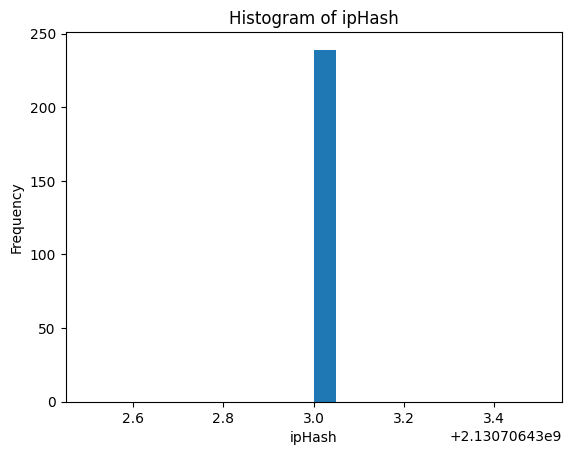

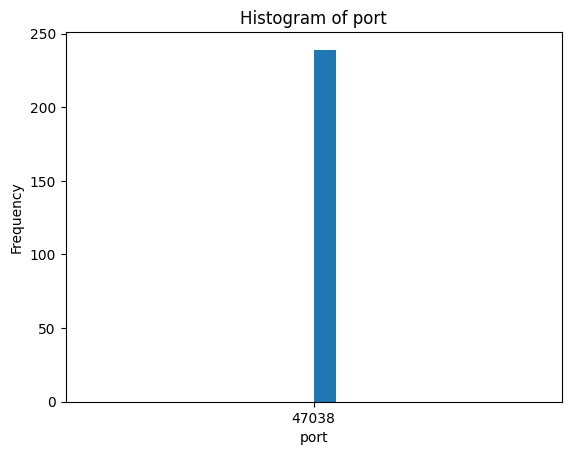

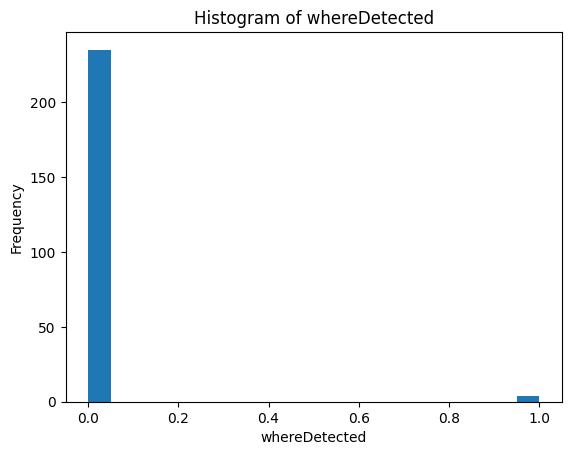

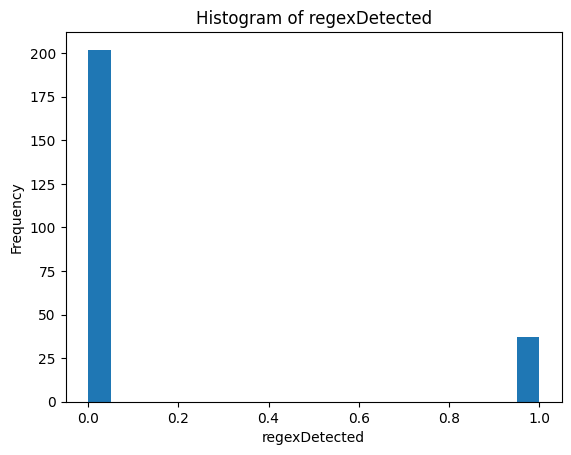

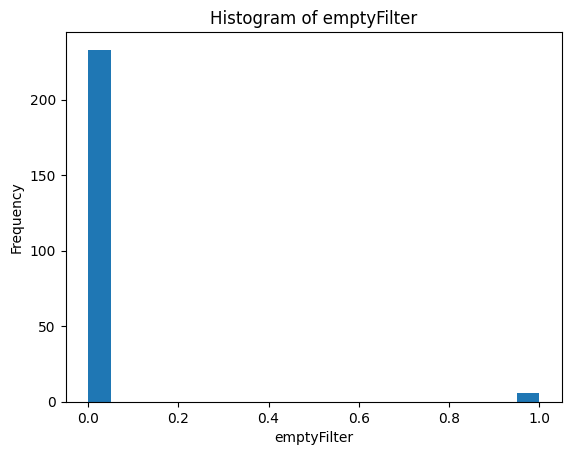

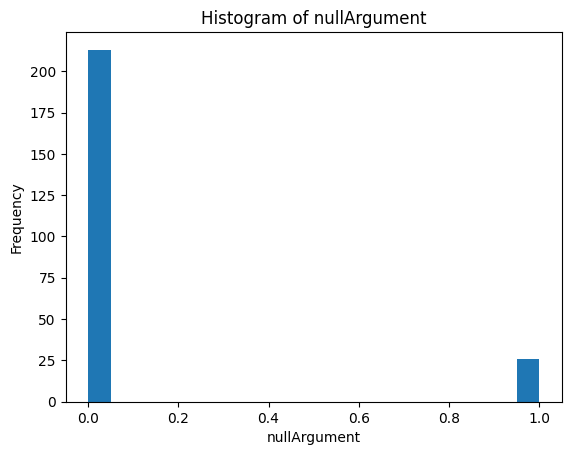

ValueError: 
{'category': 'electronics', 'price': {'$gt': 200}, 'name': {'$regex': '^S'}}
                                       ^
ParseException: Expected end of text, found '$'  (at char 39), (line:1, col:40)

<Figure size 640x480 with 1 Axes>

ValueError: 
{'name': 'name', 'name': {'$gt': 200}, 'name': {'$regex': '^S'}}
                           ^
ParseException: Expected end of text, found '$'  (at char 27), (line:1, col:28)

<Figure size 640x480 with 1 Axes>

ValueError: could not convert string to float: "{'user': '{}', 'password': '{}'}"

In [7]:
import matplotlib.pyplot as plt

# Define boolean features
boolean_features = ['whereDetected', 'regexDetected', 'emptyFilter', 'nullArgument']

# Create bar plots for boolean features
for feature in boolean_features:
    counts = final_df[feature].value_counts()
    plt.bar(counts.index.astype(str), counts)
    plt.title(f'Bar Plot of {feature}')
    plt.xlabel('Value')
    plt.ylabel('Count')
    plt.show()
